# 中文自然语言处理--聚类与关键词提取

**简介**   
大家好，我是Espresso，今天想和大家聊的是自然语言处理中常见任务，聚类（clustering）与关键词提取（keywords extraction）。   
在上一节课中，我们学习的情感分类属于监督学习，因为我们有训练数据和与之对应的标记（正面情感或负面情感），而我们今天聊的聚类属于无监督学习，我们假设有一个文本数据集，但我们并没有给他们做任何标记，我们希望能有一种算法能够自动的将数据集中联系比较密切的元素（文本）划分为一些子集。   
今天我们的目的正是使用Doc2Vec和K-means进行文本数据集聚类，并最终用TF-IDF对每个子集进行关键词提取。
在下面的代码部分，涉及到哪方面知识的，我推荐一些学习资料并附上链接，如有侵权请e-mail：a66777@188.com。

**重要说明**  
经过这段时间，我还是没能找到比较合适的语料来制作这个教程，我感到很抱歉，所以只能继续用上次用过的谭松波老师酒店评论语料进行实践，但因为酒店评论语料谈论的话题非常雷同，所以聚类和关键词提取效果并不理想。   
但是在这个课程中，我会讲明每一个过程和参数的调节，同学们可以通过调节参数对结果进行优化，或者如果有比较好的语料的话，也可以按照这里的步骤进行尝试，另外如果有同学知道哪里有比较适合学习的语料，请联系我a66777@188.com，谢谢。

**需要的库**   
numpy, pandas, matplitlib, jieba（分词）, gensim（doc2vec）,  
scikit-learn（聚类，TF-IDF）, wordcloud（词云可视化）

In [1]:
# 首先加载必用的库
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
import warnings
warnings.filterwarnings("ignore")
import os
# gensim用来实现Doc2Vec
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, TaggedLineDocument
import pandas as pd
# 让pandas显示完整文本
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings("ignore")

**处理流程：**   
**1.** 使用jieba进行分词；   
**2.** 使用gensim训练Doc2Vec模型；   
**3.** 使用scikit-learn进行K-means聚类；   
**4.** 去除语料中的stopword；   
**5.** 使用scikit-learn进行TF-IDF关键词提取，提取经过K-means聚类后子集的关键词；   
**6.** 使用wordcloud制作词云图。

首先从语料中提取文本，和上次一样：

In [2]:
# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# 每个文件夹中有2000个txt文件，每个文件中是一例评价
pos_txts = os.listdir('pos')
neg_txts = os.listdir('neg')

In [3]:
# 现在我们将所有的评价内容放置到一个list里
train_texts_orig = [] # 存储所有评价，每例评价为一条string
# 添加完所有样本之后，train_texts_orig为一个含有4000条文本的list
# 其中前2000条文本为正面评价，后2000条为负面评价
for i in range(len(pos_txts)):
    with open('pos/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('neg/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [4]:
# helper function, 去标点并分词
def process_text(text):
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    text = text.encode('utf8')
    return ' '.join(jieba.cut(text))

为gensim的Doc2Vec准备语料，我们现在要准备两个list，documents_orig是为了实现Doc2Vec转换，我们使用gensim的TaggedDocument功能：   
**TaggedDocument( words = '分词后的文本', tags = [一个list作为标记，可含若干条string] )**   
这个功能将返回一个实例，tag是我们给一段文本做的标记，**必须放在一个list里面**，否则无法被gensim正确识别，我们有了tag之后方便后续识别这段文本和进行后期处理。   
documents_list是一个长list，里面含有正常的4000条分词后的strings。

In [5]:
# 顺序正常的TaggedDocument list，其中每一个元素为一个TaggedDocument实例
documents_orig = []

# 顺序正常的长list，其中每一个元素为string（一段评语）
documents_list = []

for i, text in enumerate(train_texts_orig):
    text = process_text(text)
    documents_orig.append(TaggedDocument(text, [str(i)]))
    documents_list.append(text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jinan\AppData\Local\Temp\jieba.cache
Loading model cost 0.826 seconds.
Prefix dict has been built succesfully.


In [6]:
# 可见list中每个元素为一个实例，含有words和tags
documents_orig[0]

TaggedDocument(words='早餐 太 差 无论 去 多少 人 那边 也 不加 食品 的 酒店 应该 重视 一下 这个 问题 了 房间 本身 很 好', tags=['0'])

In [7]:
documents_list[0]

'早餐 太 差 无论 去 多少 人 那边 也 不加 食品 的 酒店 应该 重视 一下 这个 问题 了 房间 本身 很 好'

In [8]:
# 我认为最好打乱一下顺序
import random
# shuffle
documents = random.sample(documents_orig, len(documents_orig))    

**定义Doc2Vec模型**   
Doc2Vec原版论文：   
https://arxiv.org/abs/1507.07998   
Doc2Vec简短解释：  
https://www.quora.com/How-does-doc2vec-represent-feature-vector-of-a-document-Can-anyone-explain-mathematically-how-the-process-is-done   
注意dm为训练模型所用的算法，dm=1意思是‘distributed memory’（分布式记忆模型PV-DM），可以理解成是记忆当前段落中上下问中缺少的内容， 分布式记忆模型可以保留段落中词语顺序的信息， 如果dm=0则属于词袋模型(PV-DBOW)，并不保留段落中词语的顺序信息。

In [9]:
# 将段落转换为长度为300的向量
doc2vec_size = 300
# 使用分布式记忆模型
model = Doc2Vec(documents, dm=1, size=doc2vec_size)
# total_examples为词汇数量
model.train(documents, total_examples=model.corpus_count, epochs=30)

In [10]:
len(model.docvecs)

4000

In [11]:
# 返回与tag为‘50’的文本最相似的文本的tag
model.docvecs.most_similar('50')[0]

('867', 0.9421504735946655)

In [15]:
# 上面模型计算出与‘50’最相似的是‘867’，我们看一下原句
print(documents_list[50])
print(documents_list[867])

自助 早餐 非常 好 服务 很 周到 下次 还会 去 住
环境 非常 的 好 服务 也 非常 的 热情周到 下次 还会 住


In [13]:
# 由于之前的数据集已经被打乱顺序，不是很方便后续操作，所以我们用训练好的Doc2Vec模型
# 把顺序正常的分词文本用 infer_vector 转换成doc向量
# 如我们有4000个样本，doc向量的长度为300，则转换后的矩阵为（4000，300）
docs_array = np.zeros((len(documents_orig),
                       doc2vec_size))
for i, doc in enumerate(documents_orig):
    docs_array[i] = model.infer_vector(doc[0])

In [14]:
# 可视化，由于效果不理想，不做讨论
# from sklearn.decomposition import PCA
# pca= PCA(n_components=2)
# docs_pca = pca.fit_transform(docs_array)
# print(np.sum(pca.explained_variance_ratio_))
# plt.scatter(docs_pca[:2000,0], docs_pca[:2000,1], color='c', alpha=0.3)
# plt.scatter(docs_pca[2000:,0], docs_pca[2000:,1], color='r', alpha=0.3)
# plt.show()

In [27]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
# docs_tsne = tsne.fit_transform(docs_array)
# plt.scatter(docs_tsne[:2000,0], docs_tsne[:2000,1], color='c', alpha=0.3)
# plt.scatter(docs_tsne[2000:,0], docs_tsne[2000:,1], color='r', alpha=0.3)
# plt.show()

**使用K-means做文本聚类**  
我们这里使用K-means，我建议大家自己尝试下DBSCAN。

In [318]:
from sklearn.cluster import KMeans
# 聚类成子集的数量
n_clusters=8
kmeans = KMeans(n_clusters=n_clusters)
doc_k_mean = kmeans.fit(docs_array)

In [319]:
print('number of clusters: ', len(doc_k_mean.cluster_centers_))
kmeans.labels_

number of clusters:  8


array([4, 4, 4, ..., 1, 1, 3])

In [320]:
# 看一下每个子集含有样本的个数
for i in range( len(doc_k_mean.cluster_centers_) ):
    print('cluster {}: '.format(i), np.sum(kmeans.labels_==i))

cluster 0:  497
cluster 1:  919
cluster 2:  348
cluster 3:  207
cluster 4:  1331
cluster 5:  28
cluster 6:  1
cluster 7:  669


**TF-IDF关键词提取** 
TF-IDF很好理解，这个值指的是一个词在某个段落中的重要程度，TF-IDF越大，则这个词语在这个段落中就越重要。   
非常易懂的解释：   
http://www.ruanyifeng.com/blog/2013/03/tf-idf.html   
TF(term frequency)(词频):   
   
$$TF(t, d)=f_{t, d}$$
   
上式中，$t$  为一个词语，$d$  为一段文本, 可见tf的意思就是一个词语在一段文本中出现的次数；   
IDF(inverse document frequency)(逆文档频率):   
   
$$IDF(t,D)=log\frac{N}{|\{d\in{D}:t\in{d} \}|}$$
   
上式中，$t$ 为一个词语，$D$ 为语料中所有段落的集合，$N$ 为语料中段落的数量， $d$ 为一段文本， 分子意思是**语料含有的段落数量**，分母的意思是语料中**含有词语 $t$ 的段落的数量**， 比如说如果一个词出现频率极高，比如说‘的’，‘了’， 那么分子/分母就接近1，$IDF$的值就接近0。   
   
$$TFIDF(t,d,D)=TF(t,d)*IDF(t,D)$$
   
而获取TF-IDF只要把上面两式相乘。   

$TF$示例（图片来源：http://datameetsmedia.com/bag-of-words-tf-idf-explained/   ）   
<img src='tf.jpeg'>   

$TFIDF$示例：   
<img src='tfidf.jpeg'>  


**stopwords**  
上面我们已经完成聚类，现在我们来使用TF-IDF算法进行关键词提取，首先我们准备载入停用词（stop words），停用词指的是一些使用很普遍的连接词和功能词，比如说‘是’，‘然而’，‘而且’等等，这些词并没有什么实际含义，所以我们将他们去除。

In [321]:
def load_stop_words(stop_words_file_path):
    with open(stop_words_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

In [322]:
# 从事先准备好的txt文档中载入停用词
stop_words=load_stop_words("stopwords.txt")

**使用scikit-learn进行TF-IDF计算**   
**max_df**  用来忽略频率太高的词：   
比如说 max_df = 0.50 意思如果由某词语在50%以上的案例（单个文本段落）中都出现了的话，就忽略它，或者 max_df = 20 意思是忽略如果20个以上的案例都含有同一个词，就忽略它。   
**min_df**  用来忽略频率太低的词：   
比如说 min_df = 0.01 意思是如果某词语只出现在1%及以下的案例中的时候，就忽略它。

In [323]:
from sklearn.feature_extraction.text import CountVectorizer
# 注意max_df和min_df的作用
cv = CountVectorizer(max_df=0.4, 
                     min_df=10, 
                     stop_words=stop_words)
# fit and transform documents_list, 内含4000条string
word_count_vectors = cv.fit_transform(documents_list)

In [324]:
word_count_vectors.shape

(4000, 1599)

In [325]:
# cv.get_feature_names()返回一个list，可将CountVectorizer的索引map为词汇
len(list(cv.get_feature_names()))

1599

In [326]:
from sklearn.feature_extraction.text import TfidfTransformer
# 进行TF-IDF转换
tfidf_trans = TfidfTransformer(smooth_idf=True,
                               use_idf=True)
tfidf_trans.fit(word_count_vectors)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [327]:
len(tfidf_trans.idf_)

1599

In [328]:
# feature_names是一个list，含有所有提取到的词汇，可从索引map成词汇
feature_names = cv.get_feature_names()

In [329]:
# 从TF-IDF向量中提取topn个关键词
def extract_topn_keywords(feature_names, tfidf_vector, topn=10):
    # 输入:
    # feature_names: 词汇表，可将CountVectorizer的索引map为词汇
    # tfidf_vector: 经过TfidfTransformer transform的tf-idf向量
    # topn: 只输出前topn个关键词
    
    # 处理稀疏矩阵，返回一个经过排序的list，list里面为若干tuple，
    # 每一个tuple中是（词索引，tf-idf值）
    # 按tf-idf值由大到小进行排列
    def sort_vec(tfidf_vector):
        # 转换为coo矩阵以操作
        tfidf_vector = tfidf_vector.tocoo()
        # 列（col）代表词的索引
        # data是每列的值，对应tf-idf值，我们将这些转换为一些tuples
        tuples = zip(tfidf_vector.col,
                     tfidf_vector.data)
        # 按tf-idf值由大到小进行排列
        return sorted(tuples,
                      key=lambda x: (x[1], x[0]),
                      reverse=True)
    
    # 取前topn
    sorted_features = sort_vec(tfidf_vector)[:topn]
    
    # 以下我们制作一个字典
    # 其中为{‘关键词’：tf-idf值}
    feature_importances = []
    keywords = []
    for idx, importance in sorted_features:
        feature_importances.append(round(importance, 3))
        keywords.append(feature_names[idx])

    keywords_dict = {}
    for i in range(len(keywords)):
        keywords_dict[keywords[i]] = feature_importances[i]   
    return keywords_dict

In [330]:
# 我们试一下从单句中提取关键词
doc = documents_list[300]
print(len(doc))
print(doc)
test_tf_idf_vector = tfidf_trans.transform(cv.transform([doc]))
keywords = extract_topn_keywords(feature_names, 
                                 test_tf_idf_vector,
                                 topn=10)
keywords

225
环境 非常 非常 好 庭院式 小栋 别墅 虽然 说 酒店 年限 很久 了 据说 92 年 就 有 了 房间 略 小 但是 服务 环境 都 绝佳 强烈推荐 绝对 安静 唯一 不好 的 是 电视 最早 的 那种 21 寸 彩电 可能 我 住 的 房间 没 出 问题 朋友 的 房间 进去 电视 不能 开找 服务员 服务员 很快 搞定 数字电视 的 声音 变化很大 这个 频道 正常 声音 换个 频道 能 吓死人 欧洲杯 凌晨 的 声音 唉 隔壁 的 那个


{'频道': 0.467,
 '声音': 0.447,
 '电视': 0.313,
 '强烈推荐': 0.234,
 '搞定': 0.226,
 '环境': 0.215,
 '别墅': 0.214,
 '21': 0.202,
 '服务员': 0.199,
 '那种': 0.188}

In [331]:
# 可以看一下经过tf-idf转换的doc向量
# test_tf_idf_vector.todense()

In [332]:
def extract_keywords_form_cluster(cluster_id, 
                                  feature_names,
                                  documents_list,
                                  topn=15):
    # cluster_id: int, 需要提取关键词的k-means cluster id
    # feature_names: list，通过sklearn CountVectorizer.get_feature_names()
    #                得到的词汇表，可将词索引map成词汇
    # documents_list: list，一个长长的list，内含有很多小list，每个小list中含有
    #                 分词后的文本
    # topn: int，提取前topn个关键词
    
    # 首先用np.where函数得到一个当前cluster内文本索引的list
    text_id_of_cluster = np.where( kmeans.labels_ == cluster_id )[0].tolist()
    
    # 我们把当前子集内的分词后的文本全部集合到一个string里面
    len_string = ''
    for i in text_id_of_cluster:
        len_string += ( documents_list[i] + ' ' )
    
    # 对刚才准备好的string进行tf-idf转换
    cluster_tf_idf_vector = tfidf_trans.transform(
                                        cv.transform([len_string]))
    # 提取关键词
    keywords = extract_topn_keywords(feature_names=feature_names, 
                                 tfidf_vector=cluster_tf_idf_vector,
                                 topn=topn)
    return keywords

In [333]:
# 先看一下每个子集中的文本数量
for i in range( len(doc_k_mean.cluster_centers_) ):
    print('cluster {}: '.format(i), np.sum(kmeans.labels_==i))

cluster 0:  497
cluster 1:  919
cluster 2:  348
cluster 3:  207
cluster 4:  1331
cluster 5:  28
cluster 6:  1
cluster 7:  669


In [334]:
# 我不确定以子集为单位提取关键词的操作方法是否合适，如果有改善建议请联系我，谢谢
cluster_id = 0
extract_keywords_form_cluster(cluster_id, 
                              feature_names, 
                              documents_list, 
                              topn=10)

{'入住': 0.286,
 '客人': 0.271,
 '服务': 0.189,
 '宾馆': 0.189,
 '携程': 0.188,
 '前台': 0.146,
 '反馈': 0.135,
 '2008': 0.133,
 '早餐': 0.126,
 '服务员': 0.124}

In [ ]:
from wordcloud import WordCloud
# 绘制词云
def generate_wordcloud(cut_words):
    cloud = WordCloud(
        # 设置字体，将字体放入项目目录或指定绝对路径
        font_path="SimHei.ttf",
        # 设置背景色
        background_color='white',
        #允许最大词汇
        max_words=100,
        # 最大号字体
        max_font_size=50
        )
    # 生成词云
    wordcloud = cloud.generate(cut_words)
    plt.figure(figsize=(20,12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [346]:
# 准备一条关键词string用来生成词云
cluster_dict = extract_keywords_form_cluster(3, 
                                             feature_names, 
                                             documents_list, 
                                             topn=70)
cut_words = ''
for i in list(cluster_dict.keys())[5:]:
    cut_words += ' ' + i
cut_words

' 客人 服务 打电话 退房 发现 宾馆 晚上 经理 预定 小姐 第二天 结帐 空调 感觉 态度 早餐 10 东西 小时 只能 实在 客房 告诉 办法 两个 12 时间 半天 事情 希望 消费 分钟 朋友 这家 人员 告知 大堂 几个 情况 失望 回来 信用卡 回答 早上 总台 员工 点评 投诉 换房 确认 行李 卫生间 一点 下午 提出 询问 解释 登记 毛巾 补充 设施 15 地方 大床 点多'

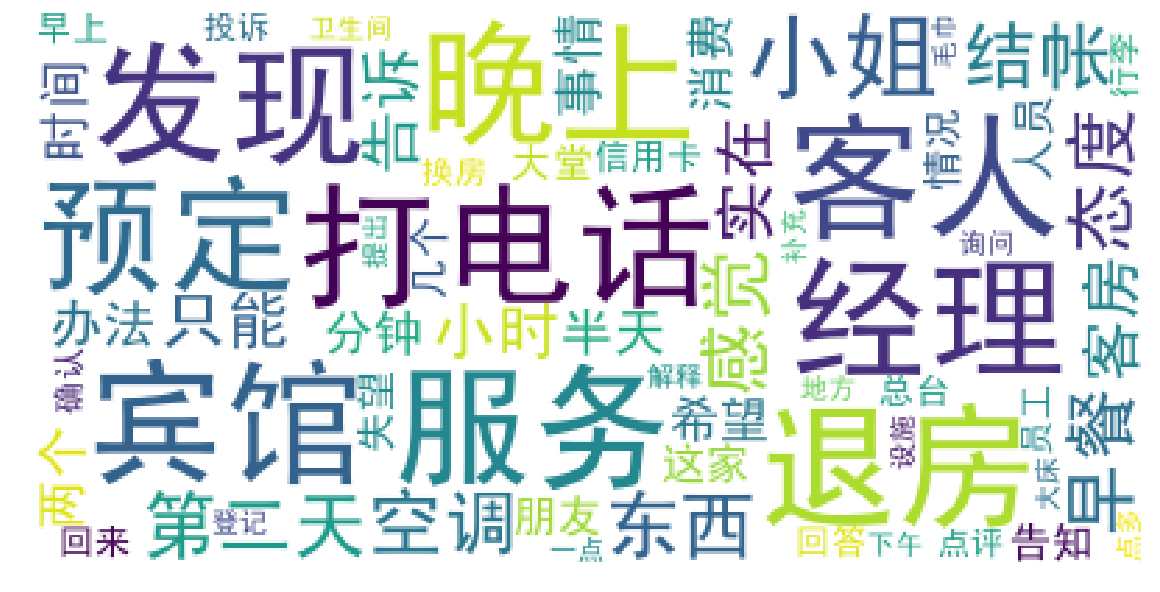

In [347]:
# 生成3号子集词云
generate_wordcloud(cut_words)

 退房 提供 浴室 前台 客人 晚上 地方 外面 巴士 2007 改善 令人 可惜 真的 客房 淋浴 补充 浴缸 套房 10 行政 原因 点评 工作 三星 西街 旅行 行李 十元 事件 唯一 身上 硬件 歉意 效率 不到 早上 吸引 只能 打算 偏僻 食物 地板 淋浴房 checkout 理解 同意


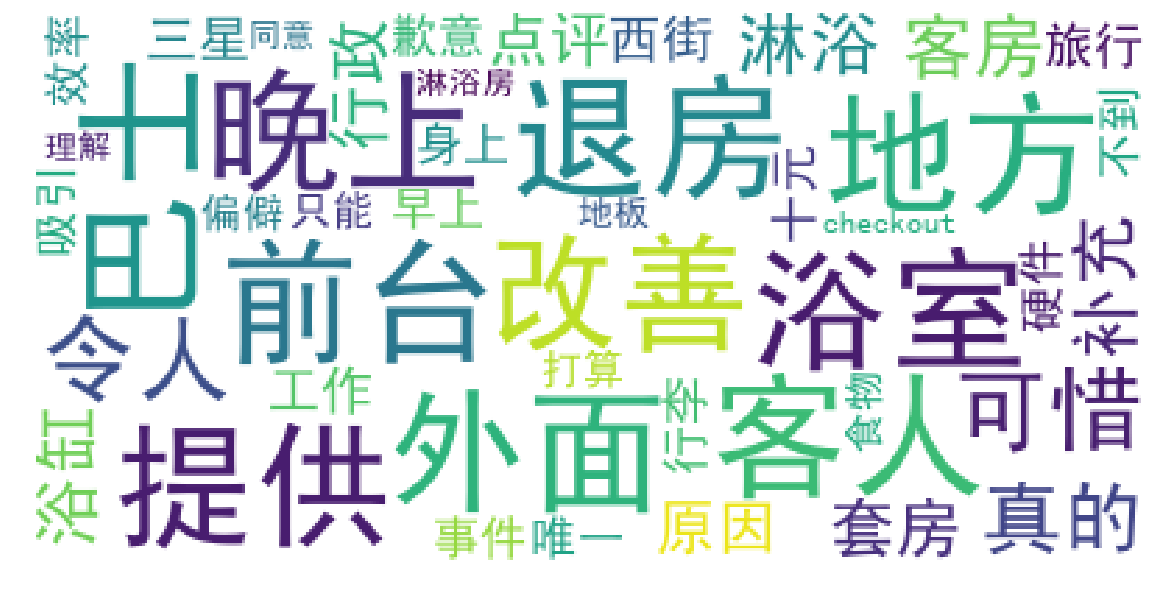

In [350]:
# 生成5号子集词云
cluster_dict = extract_keywords_form_cluster(5, 
                                             feature_names, 
                                             documents_list, 
                                             topn=50)
cut_words = ''
for i in list(cluster_dict.keys())[3:]:
    cut_words += ' ' + i
print(cut_words)
generate_wordcloud(cut_words)

In [351]:
# 我们可以把子集的文本放入pandas DataFrame里面方便查看
# 首先定义一个DataFrame，内含所有文本和与之对应的子集编号
docs_df = pd.DataFrame()
docs_df['text'] = train_texts_orig
docs_df['cluster'] = kmeans.labels_

In [352]:
# 定义一个提取当前子集的功能
def get_df_of_cluster(cluster_id, docs_df):
    cluster_df = docs_df[ docs_df.cluster == cluster_id ]
    return cluster_df

In [353]:
get_df_of_cluster(3, docs_df)

,text,cluster
27,总体很满意，但有一点需改进，我在9楼入住，走时到1楼前台结帐时由9楼层服务员检查房间，发现我有零星物品遗失在房间，我当时请他们送下来，结果答复是到4楼客房服务部去取，我到了4楼，又说服员员没时间，又要到9楼去取。当然这没什么，但是如果他们给东西送下来，哪怕是到4楼就取到了东西，我会对酒店有更好的印象。,3
314,作为4星酒店装修虽较陈旧但还可以。客房各等设备齐全。交通以的士为主。到火车站7元，关城10元，还算方便。餐厅服务态度不错，我们回来晚了，餐厅就要下班了，但仍给我们炒了拨鱼子。仅14元的生意，等了我们半天。\n\n对前台的服务就不敢恭维，非常不喜欢使用信用卡的旅客。要求我交现金，并告知使用信用卡授权无法取消。被逼无奈，我拿出钱夹给她看，里面只有130多元。这位前台登记人员竞要求我给她100元现金，就没想想我要出去吃个宵夜，打个车咋办？在我的一再坚持下，才使用了信用卡授权。其实在使用授权，及后来的取消授权和结账都非常快捷，没有丝毫的麻烦。但就不明白她为什么不让我用信用卡。就为这点事情足足耽误了好几分钟。还一再让我们在预定房价的基础上加10元可以什么随便打电话，难道我们来嘉峪关旅游就是为了在酒店里煲电话粥吗？我没同意，我告诉他我希望按预定的价格，她说那就没房了，但我说如果你不给我安排，我会去携程投诉。一听这话房子又有了。,3
389,首先我要点评一下玄武饭店6楼的房间，实在是太差了，最多只有3星级的标准；8楼以上的房间明显是重新装修过的，要好很多；我们入住的时候一下子要了6间房间，前台有位大堂副理为我们升级到豪华房，都在12楼以上的，房间就要大很多，服务态度还不错；但是令我非常愤怒的是，酒店居然不允许我从带外卖回房间吃，真是太太太可恶了，在我据理力争下，居然还有人拿着什么酒店的管理规定给我看，难道酒店的规定不让吃饭？他们让我要么出去外面吃饭，在房间吃，只能在酒店点，这样的霸王条款，我怎么能接受，我在大堂与他们几个貌似高管的人纠缠了10多分钟，他们在一楼的餐厅给我们找了个包房让我们把外卖回来的饭在里面吃，还提醒我们不要弄脏了桌布。如果不是因为这一出的话，我想我还是蛮喜欢这个酒店。但是确实因为这个，太令我失望了！,3
477,我是第一次来这家酒店入住，由于是晚上的航班，也因天气的温差问题，有些感冒，拉肚子，我本来心脏也有些不好，正担心着，这事让客房部经理发现了，前来慰问并赠送了水果。凌晨12点半，值班经理还通知了西餐厅经理为我准备了稀饭和小菜，并询问了身体状况。当时我对酒店员工的关心真的十分感动，没想到出差在外仿佛还有“家人一般的照顾”。由于是来出差，顺便自己当作旅游一下，这酒店又位于市中心，交通很便利，我自己买了份地图，服务员帮我把要出游的景点一个个都标志出来，还相应介绍了些有名的景点，给我节省了时间，也增添了我自出游玩的美好心情。过来出差来得匆忙，忘记带充电器，客房部经理得知后，还帮我找来了我手机相应的充电器。总之这次的出差，我倍受感动，也玩得很愉快。如果下次再来厦门，我一定毫不犹豫的选择宏都大饭店。,3
599,客房、前台服务还可以，就是收银方面存在问题，我有一点电话费，同她说半天，还是这样开不能那样不能，最后全部以房费名义开，给她自己方便，不给我方便。另外早上8点多走廊上吸尘气开始叫了，吵闹得很，想晚点醒好难。有时还要受服务员敲门打扫卫生困扰，这不该是一家四星酒店应该有的服务吧。总体可以，下次去可能会选。,3
691,看到网上对该酒店的评论印象不是太好，但由于它距离火车站较近，交通十分便利，所以选择了这里，入住之后感觉还不错，服务人员彬彬有礼，服务热情，在入住期间发生的一件事更让我感到该酒店的人性化服务，那天我突发心脏病，酒店服务人员及时帮我拨打了120急救中心，并连续两天在医院陪我吸氧输液，并为我提供了可口的饭菜，给予我了无微不至的关怀，当我病情有些好转要返程时行李员还帮我买了回去的火车票，临行行李员还将我送上火车，我到家后还接到该酒店大堂副理的问候电话，关心的询问我的病情并叮嘱我多注意身体，我真的非常感动，华驿让我这个身处异地的外乡人感觉到家的温暖，今后我只要到哈尔滨一定要选择入住该酒店。,3
792,"我是7-10号入住的豪华海景大床房，通过携程预定之前，曾给蓝天宾馆打过电话，当时是告知我没房了，我还比较郁闷。但是就抱着试试看的想法，在携程提交了一个订单，没想到居然给我发短信确认了！当时我还很是惊讶，因为我是带着宝宝去的，怕有误。后来到达威海后打电话给总台确认一下，告诉我预定没问题。这才放心下来。\n\n不愧是携程网友评价最高的酒店。服务比较好，还提前为我们准备好了婴儿床，整体服务员的待人接物都很礼貌热情。海景被前面的启明假日酒店破坏了一些，但还是不错的，躺在床上就可以看到海。早餐也不错，很丰富，有中式、西式、南朝鲜式，日式的。我个人喜欢西式的早餐，樱桃巧克力奶油布丁和蛋挞都不错，蛋挞还是冰过的，LP喝粥的时候小声跟我随便说了一句忘再拿个勺子了，服务员听到就给拿来，还主动为我的宝宝准备婴儿椅。我都想把早餐当午餐来吃了，哈哈。\n\n以后如果去威海度假，还住这里！\n\n提个小建议：晚报可以每天送一份，那东西不过块八毛的，我在广州住过酒店每天都给送羊城晚报。水果也可以每天送两个，一般出来玩一天回来的客人吃个桃子或小柿子还是很高兴的，成本也不过一两块，呵呵。\n\n补充点评 2008年7月11日 ： 忘记说了，第一天住在那里浴缸的下水阀似乎不严实，漏水比较快，导致我放的大半缸水漏下去不少，洗澡就只能边放水边泡澡，这就哗哗响而且不环保浪费水。第二天早上出去的时候跟服务员说了，晚上回来发现应该是处理过了，不漏了。服务还是比较上心的。但是后来，还是有些小漏，呵呵。\n\n宾馆反馈 2008年7月11日 ： 尊敬的宾客，您好，感谢您的留言！您提出的需求,我们将尽力满足，欢迎你提出宝贵的建议，也希望在您下次入住的时候为为您提供更优质的服务。",3
847,上个星期，订了两间高级房，只有这种房型才有两张床。订的时候忘记注明要双床的，但是要了四份早餐。后来，我的客人到了酒店，前台说：只订了一间大床房。我不知道携程是怎么跟圣廷苑沟通的，那天下着大雨，客人也不能转其他酒店，害我丢尽颜面。后来，携程的一个工作人员打电话过来，除了顶嘴什么事情也不能帮我解决。我认为：我订了四份早餐，虽然我忘记了说一定要双床的，可是携程也应该帮我确认一下，估计那天酒店生意好，就随便把我的房间订成大床房。后来，携程那个工作人员还说：你有可能带朋友来吃早餐才订四份早餐的，这很正常。我觉得这个服务态度也真是够差的，我一直在用携程网，现在已经是白金了，但是这样的服务态度我真的觉得很遗憾。,3
940,大堂门口外管理停车的保安不尊重客人，一辆市府领导的车停在对面，那一长条的车位就不准停车。更重要的事出言不逊，“这地方是你社会车辆能停的吗？”真让我在美国同事（懂汉语）面前觉得丢中国人的脸！,3
1069,"本来整体感觉不错,虽然价位比较高.我在入住的第二天晚上,室内温度上升到26度,问酒店的服务中心,她们说由于外面的天气比较冷(14-17度左右),现在空调只是有自然风~~~我说,外面是冷,但室内在没有窗户的情况下室温那么高,怎么睡?!最后得来的答案是酒店方面是不肯开冷空调的了,就拿了一把风扇给我!!!一家国际五星饭店居然用这种方法来处理,实在失望.除此之外,所有服务都是水准以内的.所以,以后大家去住就要选在正夏天或正冬天,否则没有空调.",3


In [354]:
get_df_of_cluster(5, docs_df)

,text,cluster
126,因為工作方便關係，常來往此酒店，交通是個很大的考量。不過現在通寶巴士和永東巴士都不跑這一間酒店，又少了一些方便。\n\n前兩天入住，前台注意到正好是我的生日，還特別安排送了一個蛋糕，感覺很窩心。,5
271,"這間酒店環境和服務態度亦算不錯,但房間空間太小~~不宣容納太大件行李~~且房間格調還可以~~\n\n中餐廳的廣東點心不太好吃~~要改善之~~~~但算價錢平宜~~可接受~~\n\n西餐廳格調都很好~~但吃的味道一般且令人等得太耐了~~要改善之~~",5
409,在中國旅行十幾年 首次住到服務如此到位 很好的酒店 很仔細熱誠 注重細節 主動的為住客提供服務 主管郝先生更是親切 感覺上遠比五星級的酒店更佳 極力的推薦大家來住這裡 絕對超乎你能想像的好服務 個人認為住過中國所有的酒店 這間是最好的,5
900,因為在鐵道大廈開會，到中裕住了兩天，一天是免費升級的套間，一天是豪華標間。設施還可以，就是冰箱裡面沒東西可消費。最近施工，早上略吵。交通還算方便。,5
1399,1月28號和朋友入住，酒店前臺是給人感覺寒磣了些，有點像老式的招待所。住的豪華標準間，在1號樓的2層，能感覺到房間很老了，但床和沙發都很舒服，而且衛生間是重新裝修過的，很有4星級的檔次。拉開窗簾，屋外的風景很好。因為沒有在酒店裡用早餐，所以對這一項沒有什么概念。在陽朔，這家酒店確實是最好的，其環境和客房完全不是西街上那些幾十到百元不等的旅店所能比擬。尤其感動的是，入住的時候因為中國南方大面積降雪的關係，電力緊張，幾度陽朔全城停電，酒店除了用自己的發電機及時發電外，服務員還特地跑到外面去買了新的暖風機給我們取暖，而且一再幫我們調試。平心而論，如果以香港、上海那些五星級酒店中經過整套西方酒店禮儀培訓的服務員為標準衡量，百樂來的服務員似乎不夠專業，但在他們的服務卻給人一種很地道的親切感。（也許我沒有碰到惡劣的服務員）建議入住的朋友多抱一些理解，不要過於用顧客就是上帝的心態挑剔。當然，如果確實有問題，還是要提出來的。再說一句，去的時候聽說6號樓正在裝修，裝修好以後硬件設施應該會有所改善吧。,5
1683,近火車站，位置方便適中。以掛三星之酒店尺度及價格置評，平心而論，委實不錯，中規中距之餘，簡直超值，是攜程的好推介，謝謝。大堂不豪華，但寬敞舒適，坐得久了，服務員奉來熱茶。花園停車場，從客房外望，視野空間，並不侷促，而且恰當綠化。提供免費上網，偶有故障，服務員都迅速有禮地協助，態度友善溫文，殊堪嘉許。客房設備足夠，衛生潔淨，是踏實的良好服務機構。來大理而又不堅持住入古城者，請考慮。\n\n补充点评 2007年10月22日 ： 同意先前有網友推介餐廳服務亦算不錯，但菜色欠吸引。,5
1801,"我喜歡這家酒店,很多年前住過,後來又住過其他的酒店,感覺還是這家好.覺得它性價比都不錯.尤其勝在周邊環境上,風景美,外出用餐也僅僅步行幾分鐘.還有個小的商業區,有百佳,吉之島等,很方便的.雖然離大的購物區比如海港城,有幾十元的車程,但如果你愿意等,有酒店提供的免費巴士,30分鐘一班到尖沙嘴,也是很方便的.還有,入住那天恰逢我生日,到大堂登記時服務生就對我說了生日快樂,晚上又送來了美味的蛋糕,一支很漂亮的紅玫瑰,還有洋酒.很開心.還有,那天因為我們去得早,11點就讓我們入住了,總之,這次入住,沒有什麽不滿意的地方.",5
1959,"服務態度很好.不管是前臺還是後勤人員,均很熱情,以禮待人;\n\n辦事效率較高.包括登記入住,結賬,客房服務等;\n\n設備維護工作尚有不足.如容易被忽視的床頭燈管老化等,建議酒店方面可以定期檢修,等到顧客反饋問題,就稍顯被動了.\n\n祝攜程旅行網及漢庭酒店越辦越好!",5
2005,"沒有或者很少無煙房間! 電梯內部不許吸煙, 但是還有一些吸煙者仍然沒有服從規則! 我是不抽煙的人, 成為二手煙的受害者! (中國13億人口中,煙民只有3.2億. 不到1/4!!!)請看到這條評論的煙民,自覺好嗎?謝謝.",5
2109,"我住的是所謂５樓行政房．雖說是無煙樓層， 但一出升降機已嗅到煙味．房間面積和設備很一般．浴室設計奇怪．浴缸外面設有淋浴花灑， 但只得半邊玻璃門阻擋水花， 所以必須很小心淋浴，以免水弄濕玻璃門外地板．浴缸外邊近地板處有明顯污漬．行政房住客可在６樓所謂行政酒廊用早餐． 食物款式少得很， 樣子亦很不吸引， 不吃都沒甚麼損失．以上述的設施，房價收費是$1,027.- 這是我在深圳付出一仟圓以上的房費住到最差的酒店. 以後也不會再住.",5


# 结论

**存在问题：**   
聚类和关键词提取的效果并不理想，可能的原因有：   
1）语料谈论的话题雷同；   
2）语料文档总数小，无法良好的获得IDF（Inverse document frequency）（逆文档频率），导致TF-IDF算法无法客观地提取关键词；   
3）调参问题；   
**改进方法：**   
1）将繁体文本转换为简体文本；   
2）调节gensim Doc2Vec建模参数，调节sklearn CountVectorizer参数，如min_df, max_df等等；   
3）使用DBSCAN来做聚类；   
4）使用其他语料。   